In [1]:
import math
import numpy as np
from scipy.sparse import coo_matrix
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib import patches

# 1

In [2]:
alphas_77 = np.load("./hs_tomography/alphas_77.npy")
alphas_195 = np.load("./hs_tomography/alphas_195.npy")
y_195 = np.load("hs_tomography/y_195.npy", allow_pickle=True)

In [3]:
def construct_X(M, alphas, Np = None):
    Np = Np if Np else math.ceil(math.sqrt(2) * M)
    No = alphas.shape[0]    # Number of orientations
    N =  No * Np            # flattened array length of intensitie measurements
    D = M * M               # flattened array length of tomogram

    # Compute two indices a and b for each pixel
    ja = np.mgrid[0:D] % M
    jb = (np.mgrid[0:D] - ja) / M

    C = np.array([ja, jb])

    # Move pixels such that the middle pixel (M/2, M/2) is in the origin of the coordinate system
    C_moved = C - np.array([[M / 2],[M / 2]])

    all_weights = []
    all_i_indices = []
    all_j_indices = []

    for io in range(No):

        alpha = np.radians(alphas[io])
        # Calculate unit vector in direction of sensor array using 2D rotation matrix
        # negate the y value, as coordinate system goes the "opposite" direction
        n = np.array([[math.cos(alpha)], [-math.sin(alpha)]])
        p = np.dot(n.T, C_moved) 

        p = p[0]

        # Center of sensor array is at origin => add half the length of the sensor array
        p = p + Np / 2

        # Calculate index of the two sensors
        idx_sensor1 = np.floor(p) + Np * io
        idx_sensor2 = np.ceil(p) + Np * io

        # Calculate the weights of the two sensors
        weight2 = p - np.floor(p)
        weight1 = 1 - weight2

        # Calculate the index of the pixels
        idx_pixel1 = np.mgrid[0:D]
        idx_pixel2 = np.mgrid[0:D]

        weights = np.append(weight1, weight2)
        idx_sensor = np.append(idx_sensor1, idx_sensor2)
        idx_pixel = np.append(idx_pixel1, idx_pixel2)

        all_weights.extend(weights)
        all_j_indices.extend(idx_pixel)
        all_i_indices.extend(idx_sensor)


    all_weights = np.array(all_weights)
    all_i_indices = np.array(all_i_indices)
    all_j_indices = np.array(all_j_indices)

    X = coo_matrix((all_weights, (all_i_indices, all_j_indices)), shape=(N, D), dtype = np.float32)
    return X

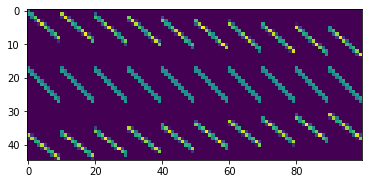

In [4]:
# verify construct_M

X_small = construct_X(M=10, alphas=np.array([-33, 1, 42]), Np=15)
plt.imshow(X_small.todense())
plt.show()

# 2

In [5]:
X = construct_X(M=195, alphas=alphas_195, Np=275)

In [6]:
def reconstruct_image(X, y, tolerance=3e-3):
    X = scipy.sparse.csc_matrix(X)
    beta, solution, *_ = scipy.sparse.linalg.lsqr(X, y, atol=tolerance, btol=tolerance)
    
    if solution != 1:
        print("system could only be solved by minimizing squared errors")

    return beta

In [7]:
beta = reconstruct_image(X, y_195)

img = beta.reshape((195, 195))

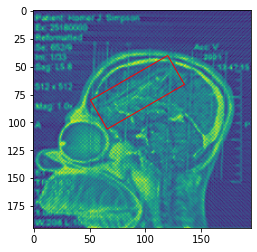

In [8]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.add_patch(patches.Rectangle((120, 40), 30, 80, angle=60, linewidth=1, edgecolor='r', facecolor='none'))
plt.show()

It seems like H.S has a crayon stuck in his brain. 

### Treatment Options

- remove it surgically
- crayons are made out of Paraffin which is soluble in petrol. So puring some of that in may help ¯\_(ツ)_/¯
- surgically insert some paper so the crayon can be useful
- maybe an actual doctor should give some recommendations as well

These options need to be discusses with H.S.

# 3

In order to know which angles we can drop we could run some experiments on the tomograph. But since we don't have any we'll just work with the one recording we have (which is admittedly a bit backwards)

In [9]:
# determine the distances of all measurements angles to each others
def compute_distances(alphas, ys):
    ys = ys.reshape((len(alphas), len(ys) // len(alphas)))
    
    return np.linalg.norm(ys[:, None, :] - ys, axis=2)

distances = compute_distances(alphas_195, y_195)

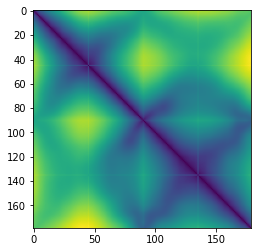

In [10]:
plt.imshow(distances)
plt.show()

In [11]:
# to make things simpler, we set the diagonal to the max value
distances += np.max(distances) * np.eye(distances.shape[0])

In [12]:
# find indicies of angles that have the closest neighbor
idx_to_remove = np.argsort(np.min(distances, axis=1))[:10]

In [13]:
def drop_angles(alphas, y, idx_to_drop):
    y = y.reshape((len(alphas), len(y) // len(alphas)))
    y = np.delete(y, idx_to_drop, axis=0)
    alphas = np.delete(alphas, idx_to_drop)
    
    return alphas, y.flatten()

In [14]:
alphas_reduced, y_reduced = drop_angles(alphas_195, y_195, idx_to_remove)
X_reduced = construct_X(len(alphas_reduced), alphas_reduced, Np=275)

In [15]:
betas_reduced = reconstruct_image(X_reduced, y_reduced)

system could only be solved by minimizing squared errors


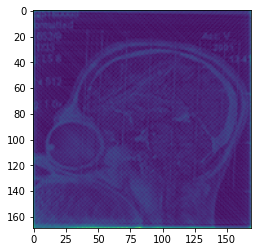

In [16]:
plt.imshow(betas_reduced.reshape((169, 169)))
plt.show()

In this version the contrast is even better but it is a lot darker.
For this to work in general it would require to take more than one picture of different materials.

A different and probably better approach would be to do something mathematical and smart like PCA or SVD.